In [1]:
# Setup
!pip -q install pandas numpy scikit-learn seaborn matplotlib joblib

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 200)

In [2]:
# =========================================
# Config: point to CSV and target column
# =========================================
from google.colab import drive
drive.mount('/content/drive')


CSV_PATH = "/content/drive/MyDrive/student_dataset/StudentPerformanceFactors.csv"

TARGET = "Exam_Score"  # e.g. 'Exam_Score' or 'G3' or 'final_score'

assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}. Upload or download it first."

df_raw = pd.read_csv(CSV_PATH)
print("Shape:", df_raw.shape)
df_raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [3]:
# =========================================
# Basic cleaning & standardization
# =========================================
df = df_raw.copy()

# Standardize column names: lowercase + underscores, strip spaces
def clean_col(c):
    c = c.strip()
    c = re.sub(r"\s+", "_", c)
    c = re.sub(r"[^0-9a-zA-Z_]", "", c)
    return c.lower()

df.columns = [clean_col(c) for c in df.columns]

# Standardize TARGET name usage
tgt_clean = clean_col(TARGET)
if tgt_clean not in df.columns:
    raise ValueError(
        f"Target column '{TARGET}' (standardized to '{tgt_clean}') not found.\n"
        f"Available columns: {list(df.columns)}"
    )

TARGET = tgt_clean

# Drop exact duplicates
before = df.shape[0]
df = df.drop_duplicates()
print(f"Dropped {before - df.shape[0]} duplicate rows.")

# Quick type fix: try numeric for obvious numeric-like columns
for col in df.columns:
    if df[col].dtype == "object":
        # if it looks numeric (with occasional non-numeric), try coercion
        coerced = pd.to_numeric(df[col], errors="coerce")
        # If at least 70% converts, accept numeric
        if coerced.notna().mean() > 0.7 and col != TARGET:
            df[col] = coerced

df.info()

Dropped 0 duplicate rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hours_studied               6607 non-null   int64 
 1   attendance                  6607 non-null   int64 
 2   parental_involvement        6607 non-null   object
 3   access_to_resources         6607 non-null   object
 4   extracurricular_activities  6607 non-null   object
 5   sleep_hours                 6607 non-null   int64 
 6   previous_scores             6607 non-null   int64 
 7   motivation_level            6607 non-null   object
 8   internet_access             6607 non-null   object
 9   tutoring_sessions           6607 non-null   int64 
 10  family_income               6607 non-null   object
 11  teacher_quality             6529 non-null   object
 12  school_type                 6607 non-null   object
 13  peer_influence        

Missing values per column:


,0
parental_education_level,90
teacher_quality,78
distance_from_home,67
hours_studied,0
access_to_resources,0
parental_involvement,0
attendance,0
extracurricular_activities,0
motivation_level,0
internet_access,0


Numeric columns: ['hours_studied', 'attendance', 'sleep_hours', 'previous_scores', 'tutoring_sessions', 'physical_activity', 'exam_score']
Categorical columns: ['parental_involvement', 'access_to_resources', 'extracurricular_activities', 'motivation_level', 'internet_access', 'family_income', 'teacher_quality', 'school_type', 'peer_influence', 'learning_disabilities', 'parental_education_level', 'distance_from_home', 'gender']


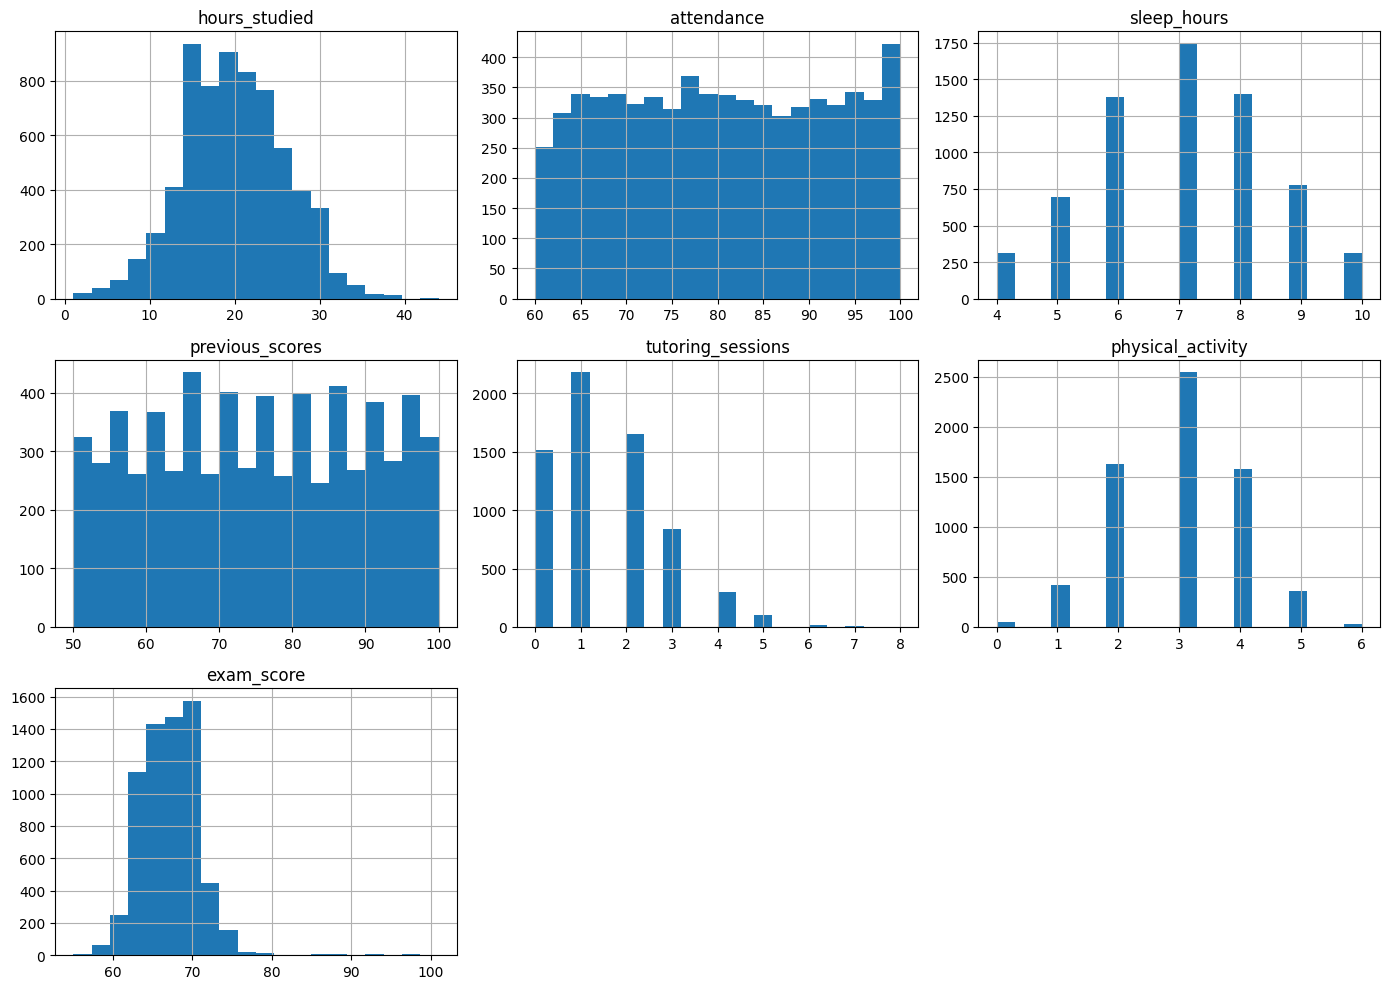

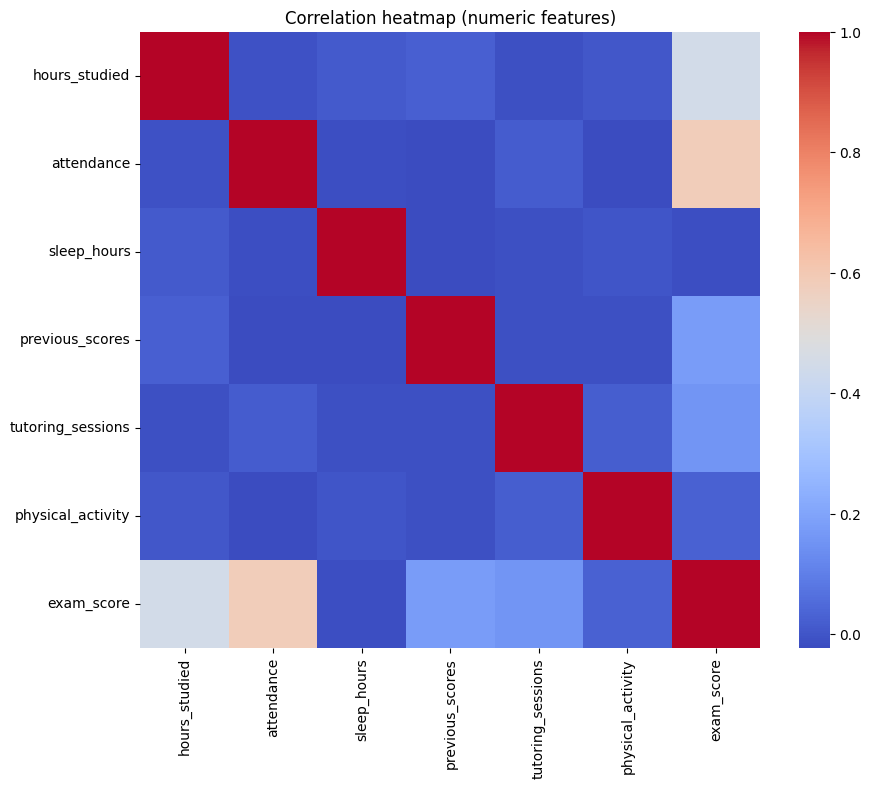

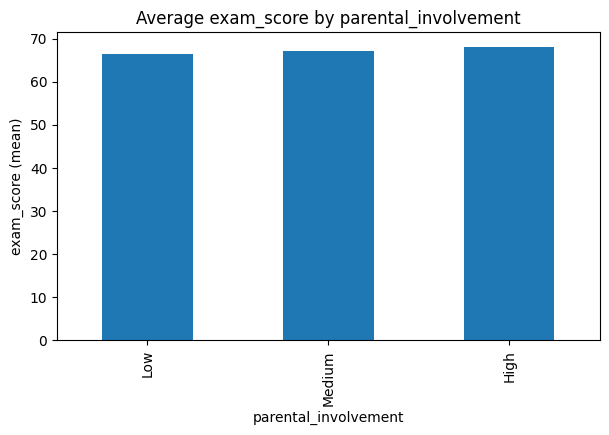

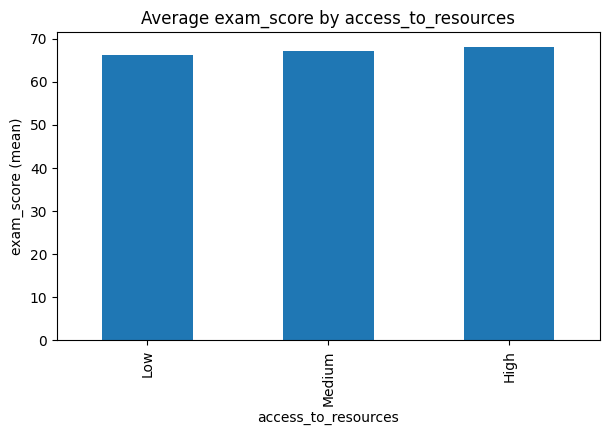

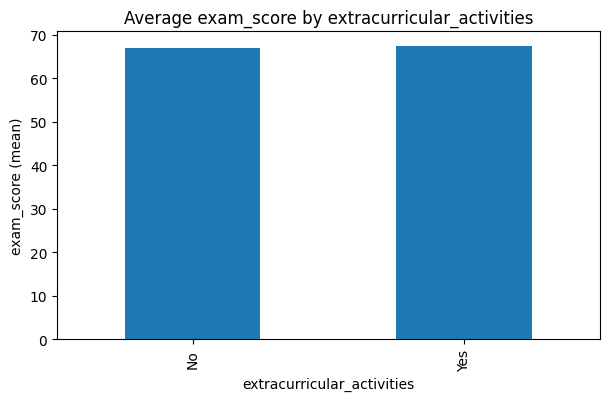

In [4]:
# =========================================
# Quick EDA
# =========================================
print("Missing values per column:")
display(df.isna().sum().sort_values(ascending=False))

# Numeric / categorical split (initial)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Histograms for numeric
_ = df[num_cols].hist(figsize=(14, 10), bins=20)
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric including target if numeric
if TARGET in num_cols:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_cols].corr(), annot=False, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation heatmap (numeric features)")
    plt.show()

# Scatter: study_hours vs target if present
possible_study_cols = [c for c in df.columns if re.search(r"study.*hour|study_hours|hours_of_study", c)]
if len(possible_study_cols) > 0 and TARGET in df.columns:
    study_col = possible_study_cols[0]
    if pd.api.types.is_numeric_dtype(df[TARGET]) and pd.api.types.is_numeric_dtype(df[study_col]):
        plt.figure(figsize=(6,4))
        sns.regplot(x=df[study_col], y=df[TARGET], ci=None)
        plt.xlabel(study_col)
        plt.ylabel(TARGET)
        plt.title(f"{study_col} vs {TARGET}")
        plt.show()

# Bar chart: target by a small categorical (<= 20 unique)
small_cats = [c for c in cat_cols if df[c].nunique() <= 20 and c != TARGET]
for c in small_cats[:3]:
    if pd.api.types.is_numeric_dtype(df[TARGET]):
        plt.figure(figsize=(7,4))
        df.groupby(c)[TARGET].mean().sort_values().plot(kind="bar")
        plt.title(f"Average {TARGET} by {c}")
        plt.ylabel(f"{TARGET} (mean)")
        plt.show()

In [5]:
# =========================================
# Train/Test split
# =========================================
# Remove rows where target is missing
df = df[df[TARGET].notna()].copy()

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Update splits after cleaning: numeric/categorical based on X only
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)

(5285, 19) (1322, 19)



=== Linear Regression (baseline) ===
 MAE_train: 0.4985
  MAE_test: 0.4524
  MSE_test: 3.2560
 RMSE_test: 1.8044
  R2_train: 0.7173
   R2_test: 0.7696


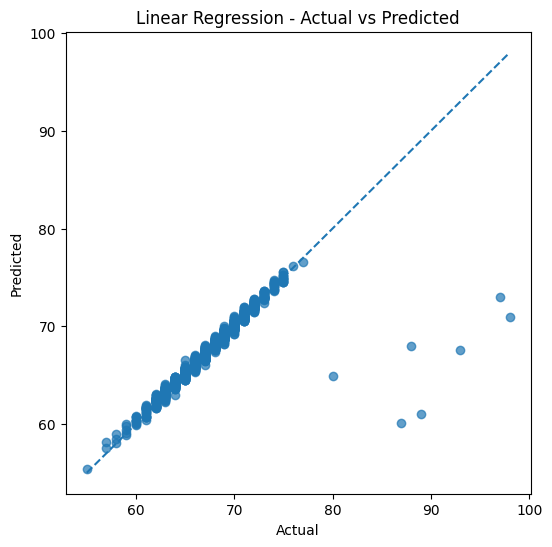

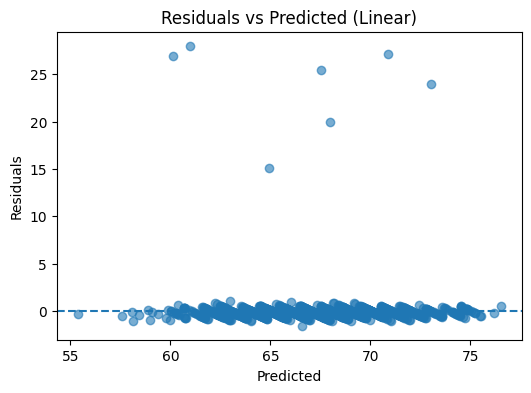

In [7]:
# =========================================
# Preprocessing + Linear Regression baseline
# =========================================


numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

linreg_model.fit(X_train, y_train)

def evaluate(model, X_tr, y_tr, X_te, y_te, label="Model"):
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    metrics = {}
    metrics["MAE_train"] = mean_absolute_error(y_tr, pred_tr)
    metrics["MAE_test"] = mean_absolute_error(y_te, pred_te)
    metrics["MSE_test"] = mean_squared_error(y_te, pred_te)
    metrics["RMSE_test"] = np.sqrt(mean_squared_error(y_te, pred_te))
    metrics["R2_train"] = r2_score(y_tr, pred_tr)
    metrics["R2_test"] = r2_score(y_te, pred_te)
    print(f"\n=== {label} ===")
    for k, v in metrics.items():
        print(f"{k:>10}: {v:.4f}")
    return pred_te, metrics

linreg_preds, linreg_metrics = evaluate(linreg_model, X_train, y_train, X_test, y_test, label="Linear Regression (baseline)")

# Plot: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, linreg_preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression - Actual vs Predicted")
plt.show()

# Residuals
resid = y_test - linreg_preds
plt.figure(figsize=(6,4))
plt.scatter(linreg_preds, resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linear)")
plt.show()

In [8]:
# =========================================
# Polynomial Regression (numeric features only)
# =========================================
poly_numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
])

preprocess_poly = ColumnTransformer(transformers=[
    ("num", poly_numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

poly_model = Pipeline(steps=[
    ("preprocess", preprocess_poly),
    ("model", LinearRegression())
])

poly_model.fit(X_train, y_train)
poly_preds, poly_metrics = evaluate(poly_model, X_train, y_train, X_test, y_test, label="Polynomial Regression (degree=2)")

# Compare models side by side
print("\nComparison (R2_test, RMSE_test):")
print(f"Linear:   R2={linreg_metrics['R2_test']:.4f}, RMSE={linreg_metrics['RMSE_test']:.4f}")
print(f"Poly d=2: R2={poly_metrics['R2_test']:.4f}, RMSE={poly_metrics['RMSE_test']:.4f}")


=== Polynomial Regression (degree=2) ===
 MAE_train: 0.5151
  MAE_test: 0.4694
  MSE_test: 3.2786
 RMSE_test: 1.8107
  R2_train: 0.7187
   R2_test: 0.7681

Comparison (R2_test, RMSE_test):
Linear:   R2=0.7696, RMSE=1.8044
Poly d=2: R2=0.7681, RMSE=1.8107


In [10]:
# =========================================
# Feature set experiments
# =========================================
def train_subset(feature_list, name):
    feats = [f for f in feature_list if f in X.columns]
    if not feats:
        print(f"[{name}] None of the requested features exist in X; skipping.")
        return None

    X_tr, X_te, y_tr, y_te = train_test_split(
        X[feats], y, test_size=0.2, random_state=RANDOM_STATE
    )

    num_sub = [c for c in feats if pd.api.types.is_numeric_dtype(X[c])]
    cat_sub = [c for c in feats if c not in num_sub]

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    prep = ColumnTransformer([
        ("num", num_pipe, num_sub),
        ("cat", cat_pipe, cat_sub)
    ])

    model = Pipeline([
        ("preprocess", prep),
        ("model", LinearRegression())
    ])

    model.fit(X_tr, y_tr)
    _, m = evaluate(model, X_tr, y_tr, X_te, y_te, label=f"Subset: {name}")
    return m


# Use cleaned (lowercase + underscores) column names
subset1 = ["hours_studied"]
subset2 = ["hours_studied", "sleep_hours"]
subset3 = ["hours_studied", "sleep_hours", "attendance", "parental_involvement"]

_ = train_subset(subset1, "Study only")
_ = train_subset(subset2, "Study + Sleep")
_ = train_subset(subset3, "Study + Sleep + Attendance + Parental Involvement")



=== Subset: Study only ===
 MAE_train: 2.5196
  MAE_test: 2.4476
  MSE_test: 10.8559
 RMSE_test: 3.2948
  R2_train: 0.1905
   R2_test: 0.2320

=== Subset: Study + Sleep ===
 MAE_train: 2.5188
  MAE_test: 2.4532
  MSE_test: 10.8983
 RMSE_test: 3.3013
  R2_train: 0.1917
   R2_test: 0.2290

=== Subset: Study + Sleep + Attendance + Parental Involvement ===
 MAE_train: 1.4501
  MAE_test: 1.3786
  MSE_test: 5.3966
 RMSE_test: 2.3231
  R2_train: 0.5591
   R2_test: 0.6182


In [11]:
# =========================================
# Cross-validated R^2
# =========================================
cv_scores = cross_val_score(linreg_model, X, y, cv=5, scoring="r2")
print("5-fold CV R^2 (Linear):", cv_scores, "Mean:", np.mean(cv_scores).round(4))


5-fold CV R^2 (Linear): [0.62563917 0.72342061 0.7082529  0.73305957 0.84044023] Mean: 0.7262


In [13]:
# =========================================
# Inspect top coefficients (linear model)
# Map pipeline coefficients back to feature names (after OHE)
# =========================================
def get_feature_names(preprocess_ct):
    """
    Extract feature names from a ColumnTransformer that has:
    - ('num', numeric_pipe, num_cols)
    - ('cat', categorical_pipe, cat_cols)
    """
    output_names = []
    for name, trans, cols in preprocess_ct.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps"):
            # numeric branch
            if "poly" in trans.named_steps:
                # polynomial features
                # Get base numeric names then let PolynomialFeatures name them
                base = cols
                poly = trans.named_steps["poly"]
                try:
                    # Newer sklearn exposes get_feature_names_out
                    poly_names = poly.get_feature_names_out(base)
                except:
                    poly_names = poly.get_feature_names(base)
                output_names.extend(poly_names)
            elif "onehot" in trans.named_steps:
                # categorical branch: handled below in else
                pass
            else:
                # plain numeric scaler (no poly)
                output_names.extend(cols)
        # handle categorical OHE explicitly
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            ohe = trans.named_steps["onehot"]
            try:
                cat_names = ohe.get_feature_names_out(cols)
            except:
                cat_names = ohe.get_feature_names(cols)
            output_names.extend(cat_names)
    return output_names

# Fit a fresh linear model (already fitted, but ensure we use the same one)
feature_names = get_feature_names(linreg_model.named_steps["preprocess"])
coef = linreg_model.named_steps["model"].coef_
coef_table = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)
coef_table.head(10), coef_table.tail(10)


(                      feature      coef
 1                  attendance  2.290405
 0               hours_studied  1.756881
 9    access_to_resources_High  1.044244
 6   parental_involvement_High  1.023711
 3             previous_scores  0.705908
 4           tutoring_sessions  0.626224
 19         family_income_High  0.582719
 14      motivation_level_High  0.532356
 22       teacher_quality_High  0.524050
 29    peer_influence_Positive  0.512149,
                                  feature      coef
 35                distance_from_home_Far -0.390690
 31             learning_disabilities_Yes -0.428606
 33  parental_education_level_High School -0.477516
 17                    internet_access_No -0.479333
 23                   teacher_quality_Low -0.491909
 15                  motivation_level_Low -0.511525
 20                     family_income_Low -0.525572
 27               peer_influence_Negative -0.539524
 7               parental_involvement_Low -0.977973
 10               access_to_

In [28]:
# =========================================
# 11) Save model and quick predict demo
# =========================================

# Choose save path in Drive
#SAVE_PATH = "/content/drive/MyDrive/student_dataset/student_score_model.pkl"

# Create folder if it doesn't exist
#os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# Save the best model
BEST_MODEL = poly_model if poly_metrics["R2_test"] > linreg_metrics["R2_test"] else linreg_model
#joblib.dump(BEST_MODEL, SAVE_PATH)
#print("Model saved at:", SAVE_PATH)

# -----------------------------
# Example: predict for a single student
# (adjust values to realistic numbers from your dataset)
# -----------------------------
example = {
    "hours_studied": 20,
    "sleep_hours": 7,
    "attendance": 90,
    "parental_involvement": "High",
    "access_to_resources": "Yes",
    "extracurricular_activities": "No",
    "previous_scores": 95,
    "motivation_level": "High",
    "internet_access": "Yes",
    "tutoring_sessions": 5,
    "family_income": "Medium",
    "teacher_quality": "High",
    "school_type": "Private",
    "peer_influence": "Positive",
    "physical_activity": 1,
    "learning_disabilities": "No",
    "parental_education_level": "Post Graduate",
    "distance_from_home": 5,           #km
    "gender": "Male"
}

# Convert to DataFrame
df_example = pd.DataFrame([example])

# Predict
pred = BEST_MODEL.predict(df_example)[0]
print(f"Predicted exam_score: {pred:.2f}")


Predicted exam_score: 73.69
